In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

### Función de Densidad Acumulada de Probabilidad Caudal Volumétrico Presa Chicayán

La siguiente función de densidad acumulada a sido ajustada con datos históricos:

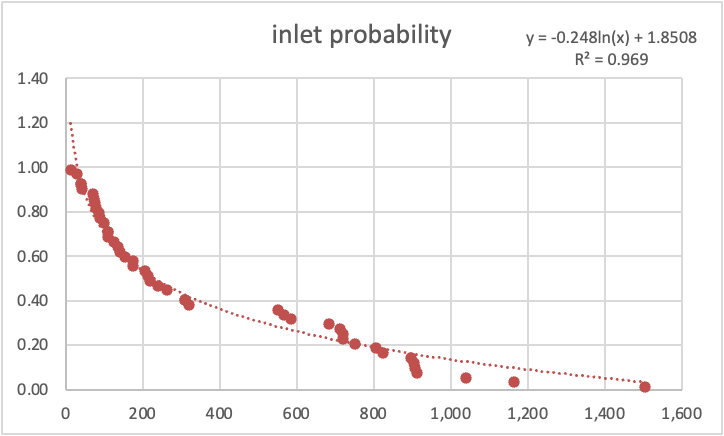

Esto sin embargo plantea una duda de por qué está invertida. Se analizará la forma de esta ECDF.

### Datos Históricos

[Text(0.5, 1.0, 'Chicayan Water Inlet Volume (Mm3)'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Volume (Mm3)')]

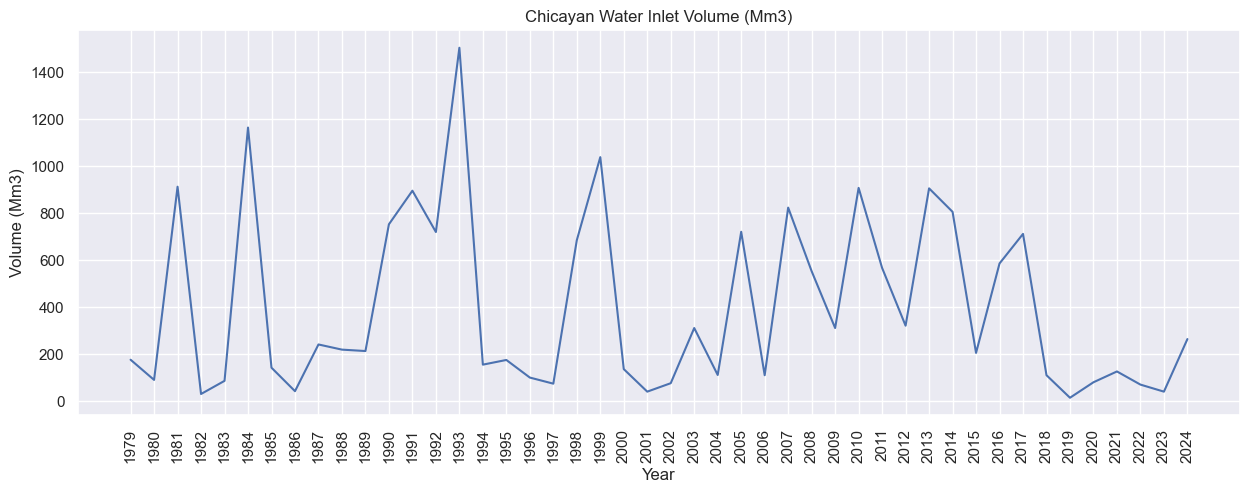

In [59]:
data = pd.read_csv(r'Inlet_Dates.csv')
serie = data['Inlet']
data['Y'] = data['Year'].str[:4]
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.lineplot(x="Y", y="Inlet",data=data).set(title="Chicayan Water Inlet Volume (Mm3)",xlabel='Year', ylabel='Volume (Mm3)')

### Distribución Acumulada Empírica de Probabilidad (ECDF)

Con el objetivo de encontrar una función analítica que represente los datos históricos de distribución acumulada, se calcula un Empirical Cumulative Distribution Function (ECDF) con la función provista por *statsmodels*

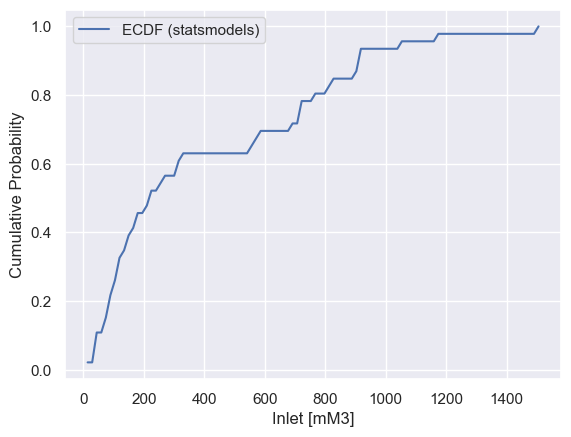

In [61]:
ecdf = ECDF(serie)
x = np.linspace(min(serie), max(serie), 100)
y = ecdf(x)

plt.plot(x, y, label='ECDF (statsmodels)')
plt.xlabel('Inlet [mM3]')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

Esta función tiene la propiedad de *ser monótona creciente* y estima la probabilidad de que un caudal sea menor o igual que un caudal específico. En otras palabras, la probabilidad de que un caudal $X$ sea a lo más un caudal específico $x$ ó $P(X) \leq x$.

Si lo que se desea es calcular la probabilidad de que un caudal $X$ sea mayor o igual a un caudal específico $x$ ó $P(X) \gt x$ entonces debe tomarse el *complemento* de esta probabilidad, es decir, $1 - P(X)$

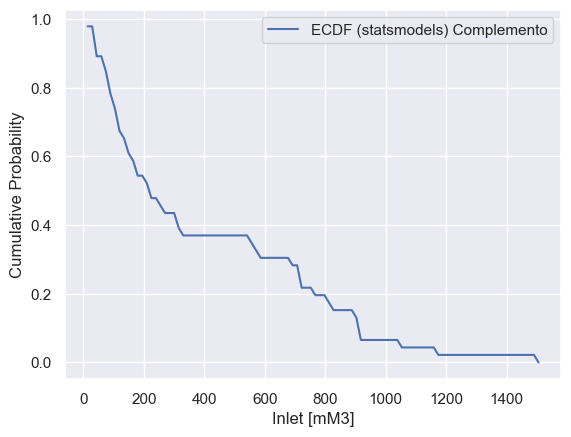

In [62]:
plt.plot(x, 1 - y, label='ECDF (statsmodels) Complemento')
plt.xlabel('Inlet [mM3]')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

### Cálculo ECDF con Rangos de Datos Históricos
Se muestra el cálculo para una ECDF $P(X) \leq x$ y una ECDF Complemento $P(X) \geq x$.
- $P(X) \leq x \Rightarrow$ Rango 1 es el valor más pequeño (orden ascendente).
- $P(X) \gt x \Rightarrow$ Rango 1 es el valor más grande (orden descendente).

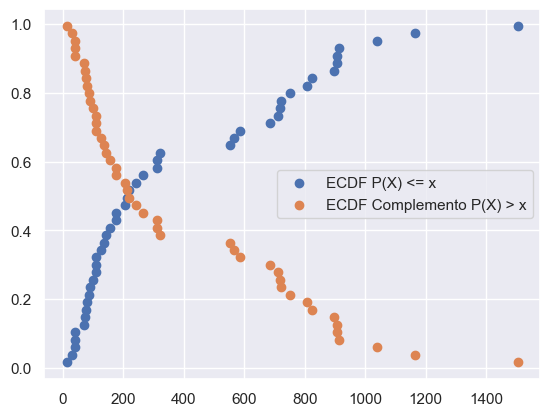

In [73]:
datos_ordenados_ascendentemente = np.sort(serie)
datos_ordenados_descendentemente = datos_ordenados_ascendentemente[::-1]
n = len(serie)

# Probabilidades según (rango - 0.25) / n
probs = np.array([(i + 1 - 0.25) / n for i in range(n)])

plt.scatter(datos_ordenados_ascendentemente,probs,label='ECDF P(X) <= x')
plt.scatter(datos_ordenados_descendentemente,probs,label='ECDF Complemento P(X) > x')
plt.legend()

Se concluye que se está mostrando una *Función Empírica de Probabilidad Acumulada Complementaria* que muestra $P(X) \gt x$, es decir, la probabilidad de que un caudal $X$ sea *al menos* un caudal específico $x$.

Para efectos de evaluación de riesgo, no es correcto utilizar esta función, pues son los *caudales bajos* los que representan peligro, por lo que es más últil conocer la probabilidad de que el caudal NO supere un valor específico, es decir $P(X) \leq x$, y por lo tanto se debería utiizar la ECDF calculada a partir de datos ordenados ascendentemente.

### Ajuste Logarítmico

Se plantea validar el ajuste logarítmico presentado. Para ello se optimiza el ajuste de una función de la forma:
$$ f(x) = a*ln(x) + b $$

In [112]:
# Definir la función logarítmica a ajustar
def log_func(x, a, b):
    return a * np.log(x) + b

In [135]:
# Ajuste
params, covariance = curve_fit(log_func, datos_ordenados_ascendentemente, probs)
a, b = params

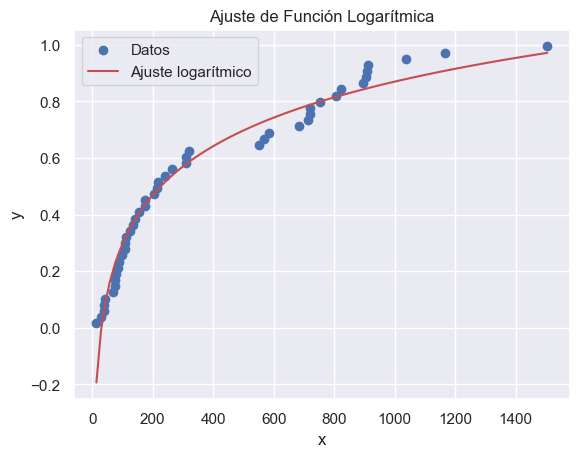

In [137]:
# Visualizar
x_fit = np.linspace(min(datos_ordenados_ascendentemente), max(datos_ordenados_ascendentemente), 100)
y_fit = log_func(x_fit, a, b)

plt.scatter(datos_ordenados_ascendentemente, probs, label='Datos')
plt.plot(x_fit, y_fit, 'r-', label='Ajuste logarítmico')
plt.title('Ajuste de Función Logarítmica')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
print("La función ajustada tiene la forma:",np.round(a,4),"ln(x) ",np.round(b,4))

La función ajustada tiene la forma: 0.2492 ln(x)  -0.8511


### Teorema de Invertibilidad de Función Acumulada

Si una variable $X$ tiene CDF $F(X)$, entonces la variable $F^{-1}(U)$, donde $U$ es una variable aleatoria uniforme entre 0 y 1, tambien tiene CDF $F(X)$:
$$ X \sim F(X) \Rightarrow F^{-1}(U) \sim F(X)$$

Esto implica que, si podemos estimar $F^{-1}(X)$ y luego simular $U$ podemos aproximar la distribución original de $X$ por medio de $F^{-1}(U)$, lo que nos permite hacer simulación de Montecarlo a partir de números aleatorios generados entre 0 y 1 con distribución uniforme.

En nuestro caso, $$F(X) = 0.2492*ln(X) - 0.8511 \Rightarrow F^{-1}(X) = 30.427*e^{4.01284X}$$

### Simulación Monte Carlo

Generamos una distribución uniforme y usamos la función inversa anterior.

In [141]:
Us = np.random.rand(10000)
F_inv_Us = 30.427*np.exp(4.01284*Us)

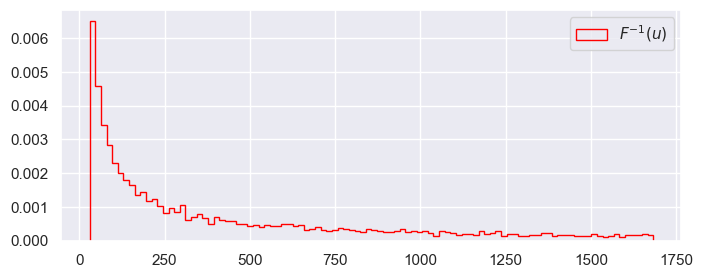

In [142]:
plt.figure(figsize=(8,3))
plt.hist(F_inv_Us, histtype='step', color = 'red', density = 'norm', bins = 100, label='$F^{-1}(u)$')
plt.legend()
plt.show()

Ahora que tenemos la aproximación de la *Distribución de Probabilidad del Caudal Volumétrico de Entrada* podemos simular valores para las secuencias a partir de números aleatorios uniformes entre 0 y 1.

In [161]:
secuencias = []
for i in np.arange(10000):
    Usim = np.random.rand(46)
    F_inv_Usim = 1757.96*np.exp(-4.01284*Usim)
    secuencias.append(F_inv_Usim)

### Estimación de Probabilidades de las Secuencias

Para las secuencias generadas, calculamos la probabilidad de ocurrir *al menos en una ocasión* cada secuencia en los próximos 10 años.

In [162]:
def sequence_probability(sequences,horizon,trials):

    def log_probability(x):
        return -0.248*np.log(x)+1.8508

    probabilities_arrays = []
    probabilities = []
    
    for i in range(len(sequences)):
        
        probability_arr = log_probability(sequences[i])

        for j in range(len(probability_arr)):
            
            if probability_arr[j] >= 1.0:
                probability_arr[j] = 0.99
        
        probabilities_arrays.append(probability_arr)
        probabilities.append(1-(1-np.prod(probability_arr[:horizon]))**(10*trials))
    
    return np.array(probabilities), probabilities_arrays

In [163]:
intentos = 2
horizonte = 10
probabilidades, arreglos_probabilidad = sequence_probability(secuencias,horizonte,intentos)

### Secuencias más Probables

Se elige un nivel de certeza y se encuentran entre la simulación las secuencias que tienen esa probabilidad o más de ocurrir.

In [200]:
nivel_certeza = 0.8

indices = np.where(probabilidades >= nivel_certeza)

print("La(s) secuencia(s)",indices[0],"de la simulación tiene(n) una probabilidad de al menos",nivel_certeza*100,"%")
print("------------------------------------------------------------------------------------------------")
for indice in indices[0]:
    print("Secuencia",indice,":",secuencias[indice],"con probabilidad",np.round(probabilidades[indice]*100,2),"%")

La(s) secuencia(s) [3188] de la simulación tiene(n) una probabilidad de al menos 80.0 %
------------------------------------------------------------------------------------------------
Secuencia 3188 : [  59.35822305   55.48286325   34.17709739  148.79047292   38.97260472
   46.68295054  146.61038147  193.43288437   44.26779177   91.73915468
  116.72747885   99.92769832  375.37601123  308.01991337   62.63787017
  276.2443224   179.84054408  386.54162787   38.11918511 1426.97328892
   99.77129279  162.67509017 1524.12159247   91.58466353  208.34486349
  934.01714195  354.44239295  107.78609054 1688.84606856  424.45289025
  206.34654512  766.97606034  187.39961841   86.72195942 1040.13844767
  249.67030585   50.01614017  133.70696152 1741.66911173  155.05859843
  265.33058394  115.30869231  497.9174603   806.69119811   66.30293049
  979.89699531] con probabilidad 81.22 %


In [199]:
def balance_hidrico(inlet_sequence,max_volume,irrigation_outlet,losses):

    balance = []
    max_irrigation_outlet = 0
    min_volume = 135
    balance_previous_year = 229.36

    for i in range(len(inlet_sequence)):
        Vt = inlet_sequence[i] + balance_previous_year
        overflow = max(Vt-max_volume,0)
        net_volume = max(Vt - overflow - irrigation_outlet - losses,0)
        operative_volume = net_volume - min_volume

        registro = [2025+i,inlet_sequence[i],Vt,overflow,balance_previous_year,net_volume,operative_volume]

        balance.append(registro)
    
        balance_previous_year = net_volume

    df = pd.DataFrame(balance,columns=['year','inlet','Vt','overflow','balance_previous_year','net_volume','operative_volume'])
    deficit_count = df[df['operative_volume']<0]['year'].count()

    print("Con una capacidad de",max_volume,"Mm3, un consumo de",irrigation_outlet,"Mm3 y unas pérdidas de",losses,"Mm3, el número de años esperado con déficit en los próximos",horizonte,"años es:",deficit_count)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['year'],df['operative_volume'])
    plt.title("Volumen Operativo [Mm3]")
    plt.xlabel("Año")
    plt.ylabel("Volumen Operativo [Mm3]")
    plt.grid(True)
    
    return deficit_count,df

Con una capacidad de 300 Mm3, un consumo de 50 Mm3 y unas pérdidas de 18 Mm3, el número de años esperado con déficit en los próximos 10 años es: 0


,year,inlet,Vt,overflow,balance_previous_year,net_volume,operative_volume
0,2025,59.358223,288.718223,0.000000,229.360000,220.718223,85.718223
1,2026,55.482863,276.201086,0.000000,220.718223,208.201086,73.201086
2,2027,34.177097,242.378184,0.000000,208.201086,174.378184,39.378184
3,2028,148.790473,323.168657,23.168657,174.378184,232.000000,97.000000
4,2029,38.972605,270.972605,0.000000,232.000000,202.972605,67.972605
5,2030,46.682951,249.655555,0.000000,202.972605,181.655555,46.655555
6,2031,146.610381,328.265937,28.265937,181.655555,232.000000,97.000000
7,2032,193.432884,425.432884,125.432884,232.000000,232.000000,97.000000
8,2033,44.267792,276.267792,0.000000,232.000000,208.267792,73.267792
9,2034,91.739155,300.006946,0.006946,208.267792,232.000000,97.000000


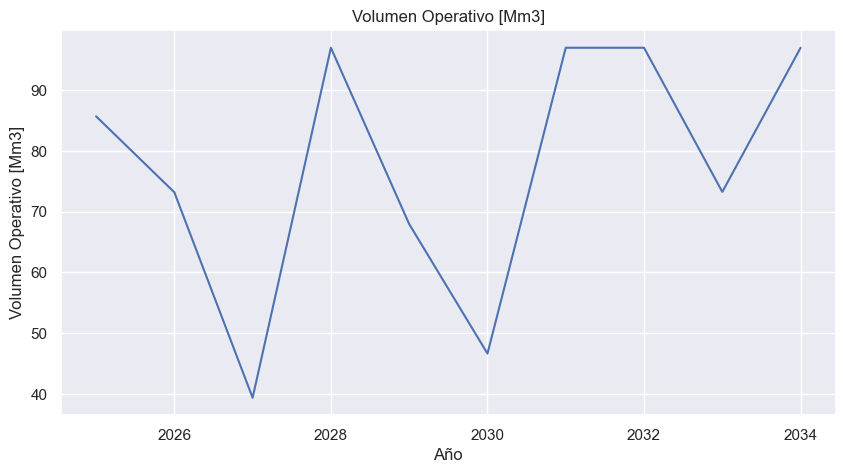

In [209]:
numero_secuencia = 3188
volumen_maximo = 300
salida_irrigacion = 50
perdidas = 18
años_deficit_secuencia_probable, secuencia_probable = balance_hidrico(secuencias[numero_secuencia][:horizonte],volumen_maximo,salida_irrigacion,perdidas)
secuencia_probable